<a href="https://colab.research.google.com/github/angiegh2002/nn/blob/main/lung_cancer_detection%20(8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!pip install tensorflow

#MULTI CLASSIFICATION

In [3]:
!kaggle datasets download rm1000/lung-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.55G/1.55G [01:18<00:00, 22.5MB/s]
100% 1.55G/1.55G [01:18<00:00, 21.1MB/s]


In [4]:
!unzip /content/lung-cancer-histopathological-images.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/squamous_cell_carcinoma/0000.jpg  
  inflating: data/squamous_cell_carcinoma/0001.jpg  
  inflating: data/squamous_cell_carcinoma/0002.jpg  
  inflating: data/squamous_cell_carcinoma/0003.jpg  
  inflating: data/squamous_cell_carcinoma/0004.jpg  
  inflating: data/squamous_cell_carcinoma/0005.jpg  
  inflating: data/squamous_cell_carcinoma/0006.jpg  
  inflating: data/squamous_cell_carcinoma/0007.jpg  
  inflating: data/squamous_cell_carcinoma/0008.jpg  
  inflating: data/squamous_cell_carcinoma/0009.jpg  
  inflating: data/squamous_cell_carcinoma/0010.jpg  
  inflating: data/squamous_cell_carcinoma/0011.jpg  
  inflating: data/squamous_cell_carcinoma/0012.jpg  
  inflating: data/squamous_cell_carcinoma/0013.jpg  
  inflating: data/squamous_cell_carcinoma/0014.jpg  
  inflating: data/squamous_cell_carcinoma/0015.jpg  
  inflating: data/squamous_cell_carcinoma/0016.jpg  
  inflating: data/squamous_cell_carcinoma/0017.j

In [7]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense ,Flatten,Dropout
from tensorflow.keras.optimizers import Adamax, Adam, SGD, RMSprop
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
# import talos
from sklearn.metrics import confusion_matrix

In [8]:
data_dir = "/content/data"
image_data = [
    {"image_path": image_file, "label": label}
    for label in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, label))
    for image_file in glob(os.path.join(data_dir, label, "*.jpg"))
]

lung_df = pd.DataFrame(image_data)

In [9]:
lung_df.head()

,image_path,label
0,/content/data/adenocarcinoma/4804.jpg,adenocarcinoma
1,/content/data/adenocarcinoma/0180.jpg,adenocarcinoma
2,/content/data/adenocarcinoma/3694.jpg,adenocarcinoma
3,/content/data/adenocarcinoma/3915.jpg,adenocarcinoma
4,/content/data/adenocarcinoma/3767.jpg,adenocarcinoma


In [10]:
lung_df.describe()

,image_path,label
count,15000,15000
unique,15000,3
top,/content/data/squamous_cell_carcinoma/0430.jpg,adenocarcinoma
freq,1,5000


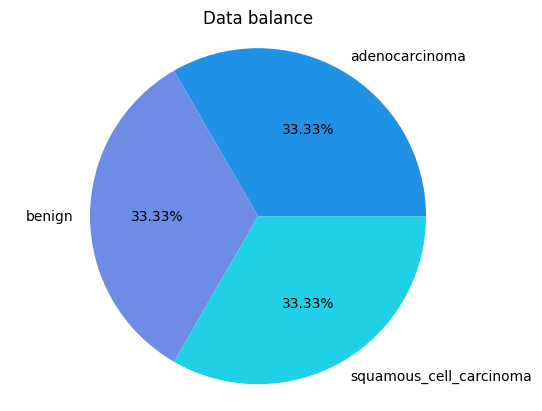

In [11]:
data_balance = lung_df.label.value_counts()
plt.pie(data_balance, labels = data_balance.index, autopct='%1.2f%%', colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

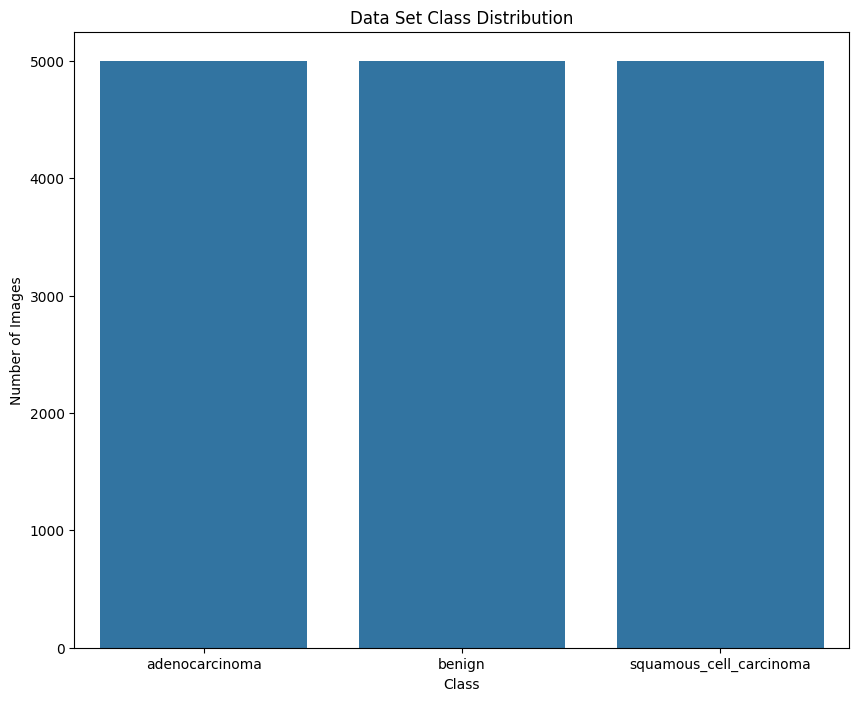

In [12]:
plt.subplots(figsize=(10,8))
sns.countplot(data=lung_df,x="label")
plt.title('Data Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [13]:
# lung_key = {'adenocarcinoma' : 1, 'benign' : 0,'squamous_cell_carcinoma' : 2}

# lung_df['label'] = lung_df['label'].map(lung_key)
# lung_df.head(10)

In [14]:
train_df, ts_df = train_test_split(lung_df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [15]:
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [16]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'b', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'b', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [17]:
def print_confusion_matrix(model, test_gen):
  y_true = test_gen.classes
  y_pred = model.predict(test_gen)
  y_pred = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

In [19]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [20]:
model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adamax(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history=model.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 180ms/step - accuracy: 0.6176 - loss: 5.4031 - val_accuracy: 0.7300 - val_loss: 0.6142
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.7372 - loss: 0.7269 - val_accuracy: 0.6893 - val_loss: 0.6941
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 63s 168ms/step - accuracy: 0.7338 - loss: 0.6995 - val_accuracy: 0.7313 - val_loss: 0.5813
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - accuracy: 0.7415 - loss: 0.6612 - val_accuracy: 0.7667 - val_loss: 0.5008
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 148ms/step - accuracy: 0.7514 - loss: 0.5696 - val_accuracy: 0.7200 - val_loss: 0.7294
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - accuracy: 0.7454 - loss: 0.5613 - val_accuracy: 0.7693 - val_loss: 0.4827
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.7691 - loss: 0.4733 - val_accuracy: 0.7533 - val_loss: 0.5113
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 171ms/step - accuracy: 0.7585 - loss: 0.5002 - val

In [21]:
loss, accuracy = model.evaluate(valid_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 76%
Model Loss : 49%


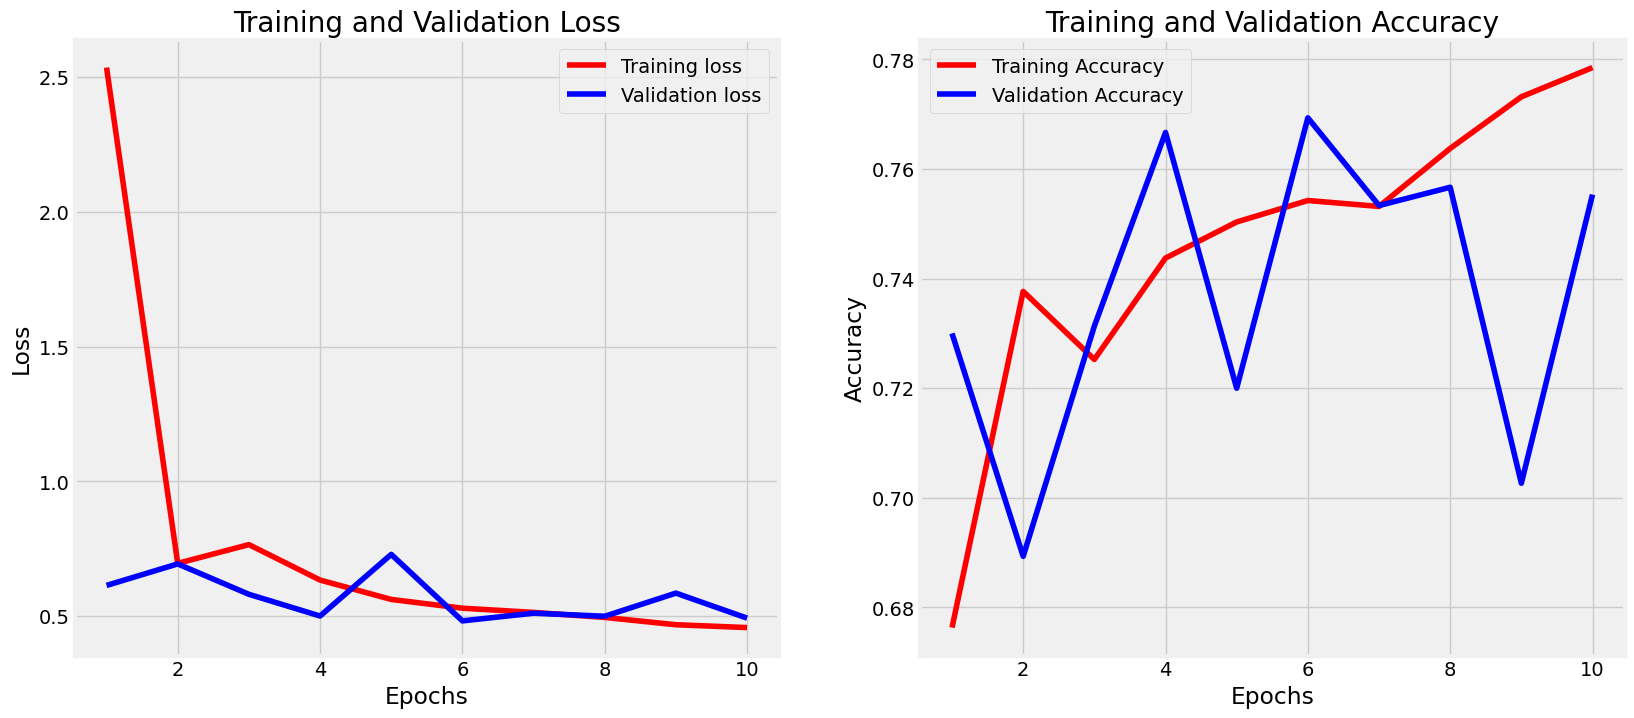

In [22]:
model_performance(history, 10)

In [23]:
model1 = Sequential()
model1.add(Input(shape=img_shape))
model1.add(Flatten())
model1.add(Dense(256, activation = 'relu'))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(class_counts, activation = 'softmax'))

model1.compile(Adamax(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history1=model1.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 179ms/step - accuracy: 0.6237 - loss: 3.5291 - val_accuracy: 0.7387 - val_loss: 0.5420
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 160ms/step - accuracy: 0.7355 - loss: 0.5791 - val_accuracy: 0.7727 - val_loss: 0.4823
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.7440 - loss: 0.5913 - val_accuracy: 0.7120 - val_loss: 0.6173
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 179ms/step - accuracy: 0.7438 - loss: 0.5890 - val_accuracy: 0.7500 - val_loss: 0.5401
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 170ms/step - accuracy: 0.7660 - loss: 0.5040 - val_accuracy: 0.7360 - val_loss: 0.5185
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.7553 - loss: 0.5071 - val_accuracy: 0.6667 - val_loss: 0.6628
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 63s 167ms/step - accuracy: 0.7572 - loss: 0.5134 - val_accuracy: 0.7140 - val_loss: 0.5355
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.7518 - loss: 0

In [24]:
loss, accuracy = model1.evaluate(valid_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 76%
Model Loss : 47%


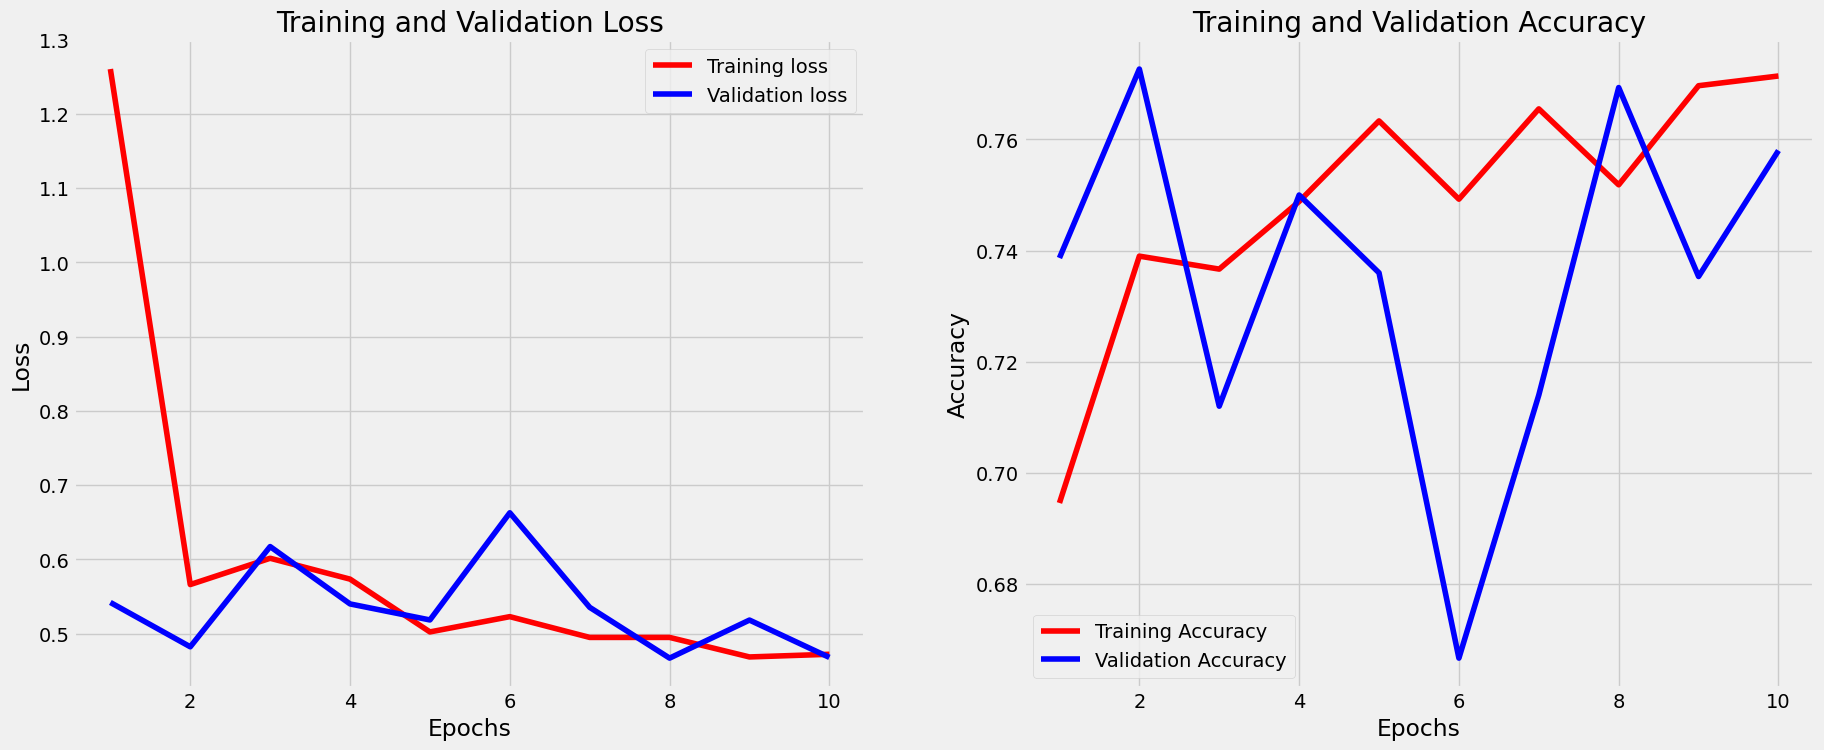

In [26]:
model_performance(history1, 10)

In [27]:
model2 = Sequential()
model2.add(Input(shape=img_shape))
model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(32, activation = 'relu'))
model2.add(Dense(class_counts, activation = 'softmax'))

model2.compile(Adamax(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history2=model2.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 157ms/step - accuracy: 0.5990 - loss: 4.4870 - val_accuracy: 0.6360 - val_loss: 3.1813
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.7280 - loss: 1.2515 - val_accuracy: 0.7587 - val_loss: 0.7705
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - accuracy: 0.7418 - loss: 1.0754 - val_accuracy: 0.7400 - val_loss: 0.6827
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - accuracy: 0.7552 - loss: 0.7937 - val_accuracy: 0.6607 - val_loss: 1.3586
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - accuracy: 0.7457 - loss: 0.7204 - val_accuracy: 0.6840 - val_loss: 0.9798
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 171ms/step - accuracy: 0.7536 - loss: 0.5717 - val_accuracy: 0.7013 - val_loss: 0.8102
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.7540 - loss: 0.5674 - val_accuracy: 0.6220 - val_loss: 0.8616
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - accuracy: 0.7609 - loss: 0

In [28]:
loss, accuracy = model2.evaluate(valid_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 74%
Model Loss : 51%


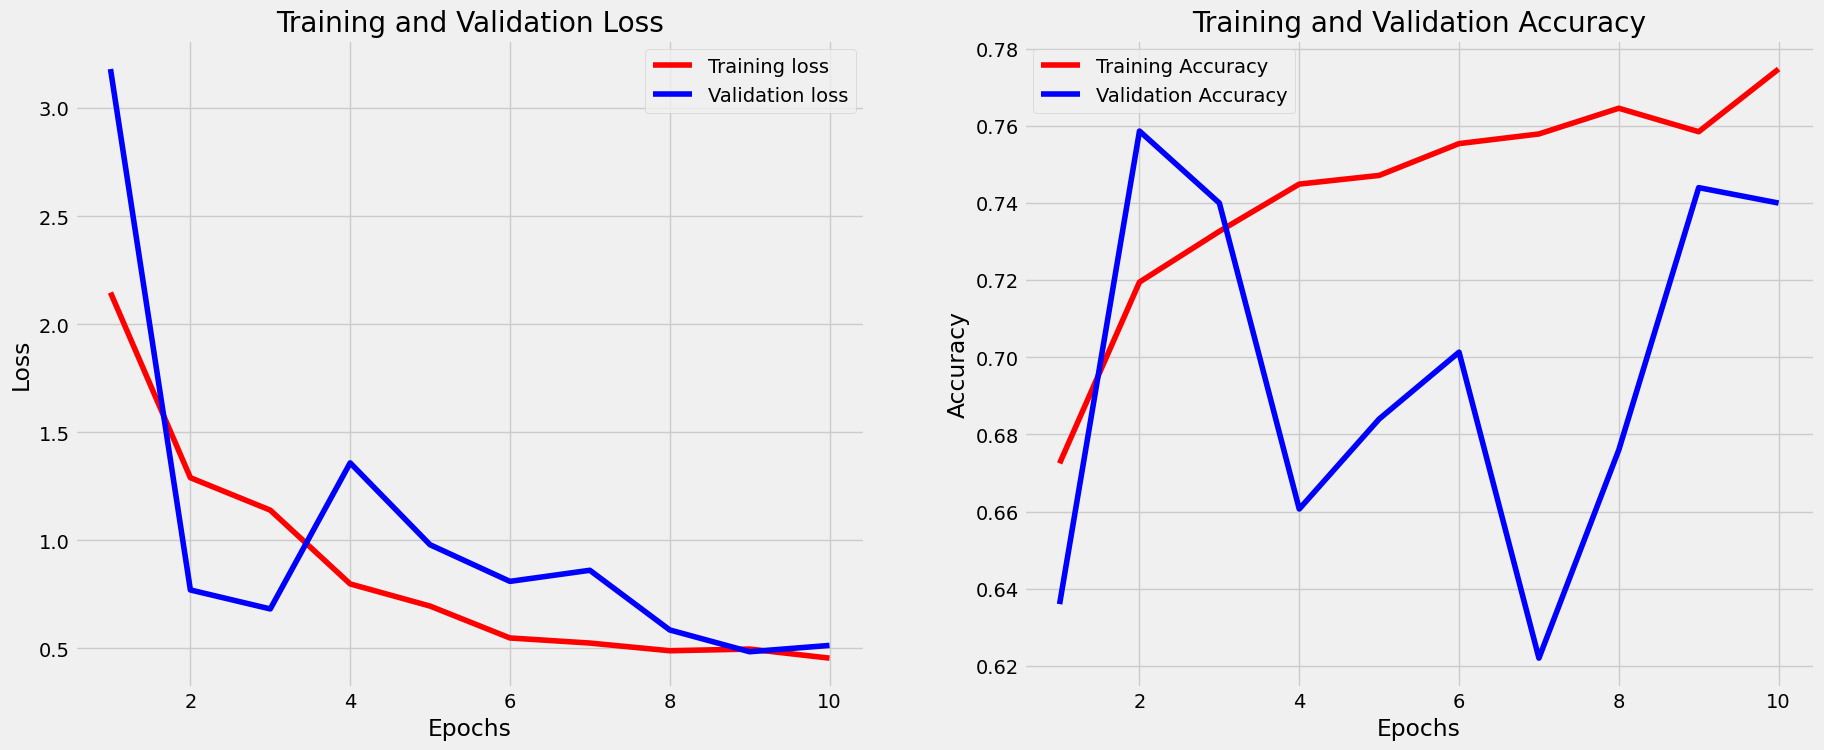

In [29]:
model_performance(history2, 10)

In [32]:
model3 = Sequential()
model3.add(Input(shape=img_shape))
model3.add(Flatten())
model3.add(Dense(256, activation = 'tanh'))
model3.add(Dense(128, activation = 'tanh'))
model3.add(Dense(64, activation = 'tanh'))
model3.add(Dense(class_counts, activation = 'softmax'))

model3.compile(Adamax(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history3=model3.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 157ms/step - accuracy: 0.5559 - loss: 1.0396 - val_accuracy: 0.6207 - val_loss: 0.5810
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 184ms/step - accuracy: 0.6478 - loss: 0.5712 - val_accuracy: 0.7053 - val_loss: 0.5843
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - accuracy: 0.6777 - loss: 0.5696 - val_accuracy: 0.6280 - val_loss: 0.6216
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.6566 - loss: 0.5931 - val_accuracy: 0.6280 - val_loss: 0.6525
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.6504 - loss: 0.5965 - val_accuracy: 0.6313 - val_loss: 0.6274
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 148ms/step - accuracy: 0.6559 - loss: 0.5691 - val_accuracy: 0.6253 - val_loss: 0.6188
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - accuracy: 0.6536 - loss: 0.5604 - val_accuracy: 0.6360 - val_loss: 0.6214
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - accuracy: 0.6443 - loss: 0

In [33]:
loss, accuracy = model3.evaluate(valid_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 64%
Model Loss : 56%


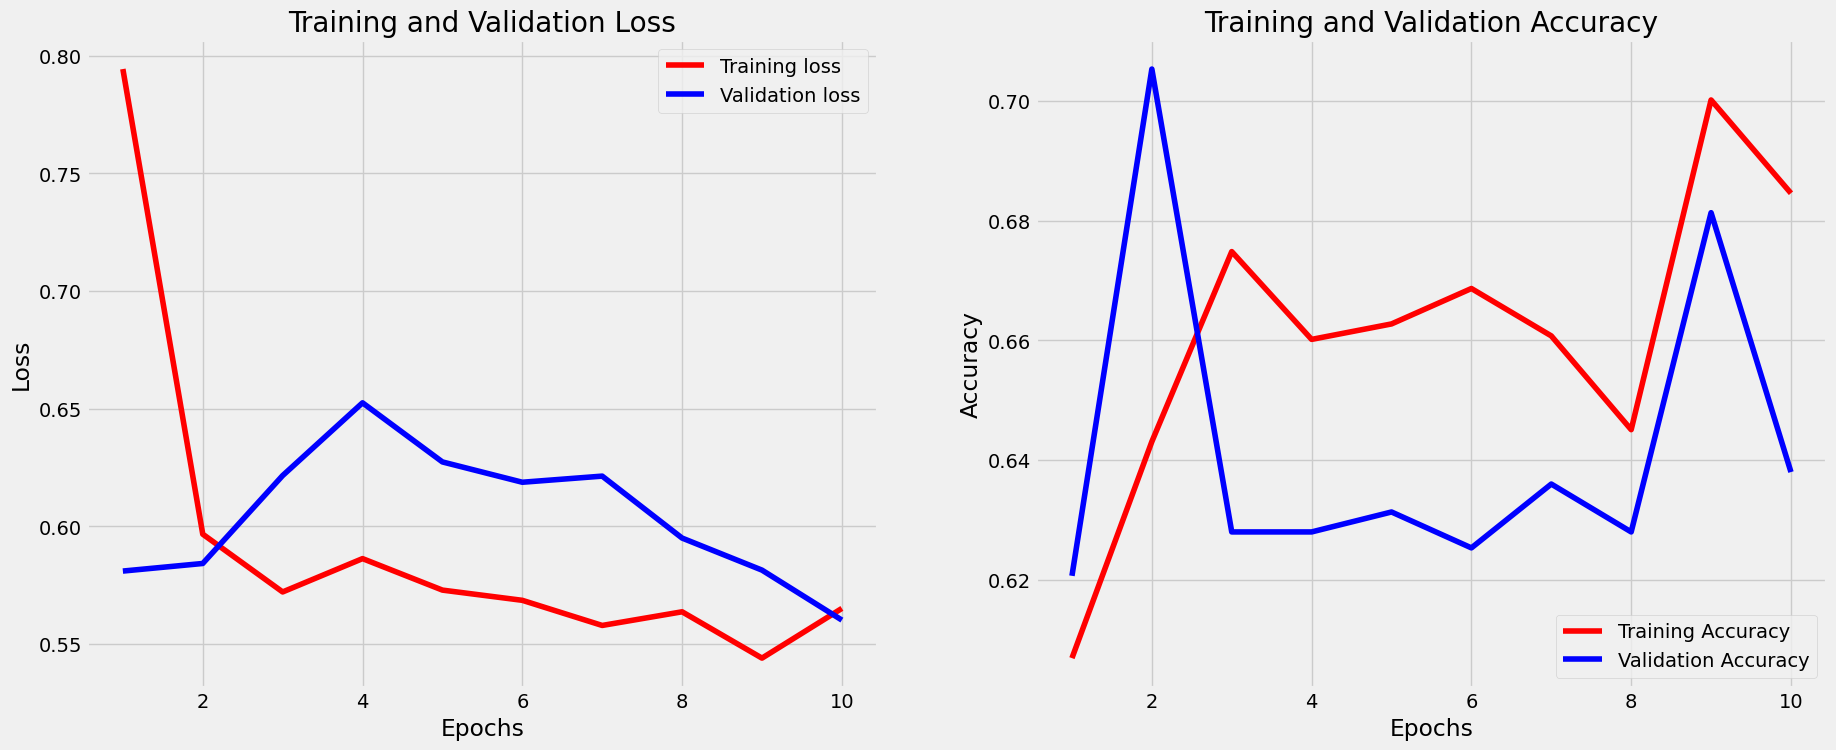

In [34]:
model_performance(history3, 10)

In [36]:
model4 = Sequential()
model4.add(Input(shape=img_shape))
model4.add(Flatten())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(class_counts, activation = 'softmax'))

model4.compile(Adamax(learning_rate= 0.01),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history4=model4.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 185ms/step - accuracy: 0.5425 - loss: 152.6641 - val_accuracy: 0.7080 - val_loss: 0.6834
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.7219 - loss: 0.6957 - val_accuracy: 0.7647 - val_loss: 0.4924
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - accuracy: 0.7401 - loss: 0.6043 - val_accuracy: 0.7673 - val_loss: 0.4689
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - accuracy: 0.7638 - loss: 0.5156 - val_accuracy: 0.7373 - val_loss: 0.5094
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - accuracy: 0.7032 - loss: 0.6718 - val_accuracy: 0.7680 - val_loss: 0.4909
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - accuracy: 0.7299 - loss: 0.5432 - val_accuracy: 0.7360 - val_loss: 0.5417
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - accuracy: 0.7520 - loss: 0.4978 - val_accuracy: 0.7387 - val_loss: 0.5412
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 162ms/step - accuracy: 0.7682 - loss:

In [37]:
loss, accuracy = model4.evaluate(valid_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 66%
Model Loss : 58%


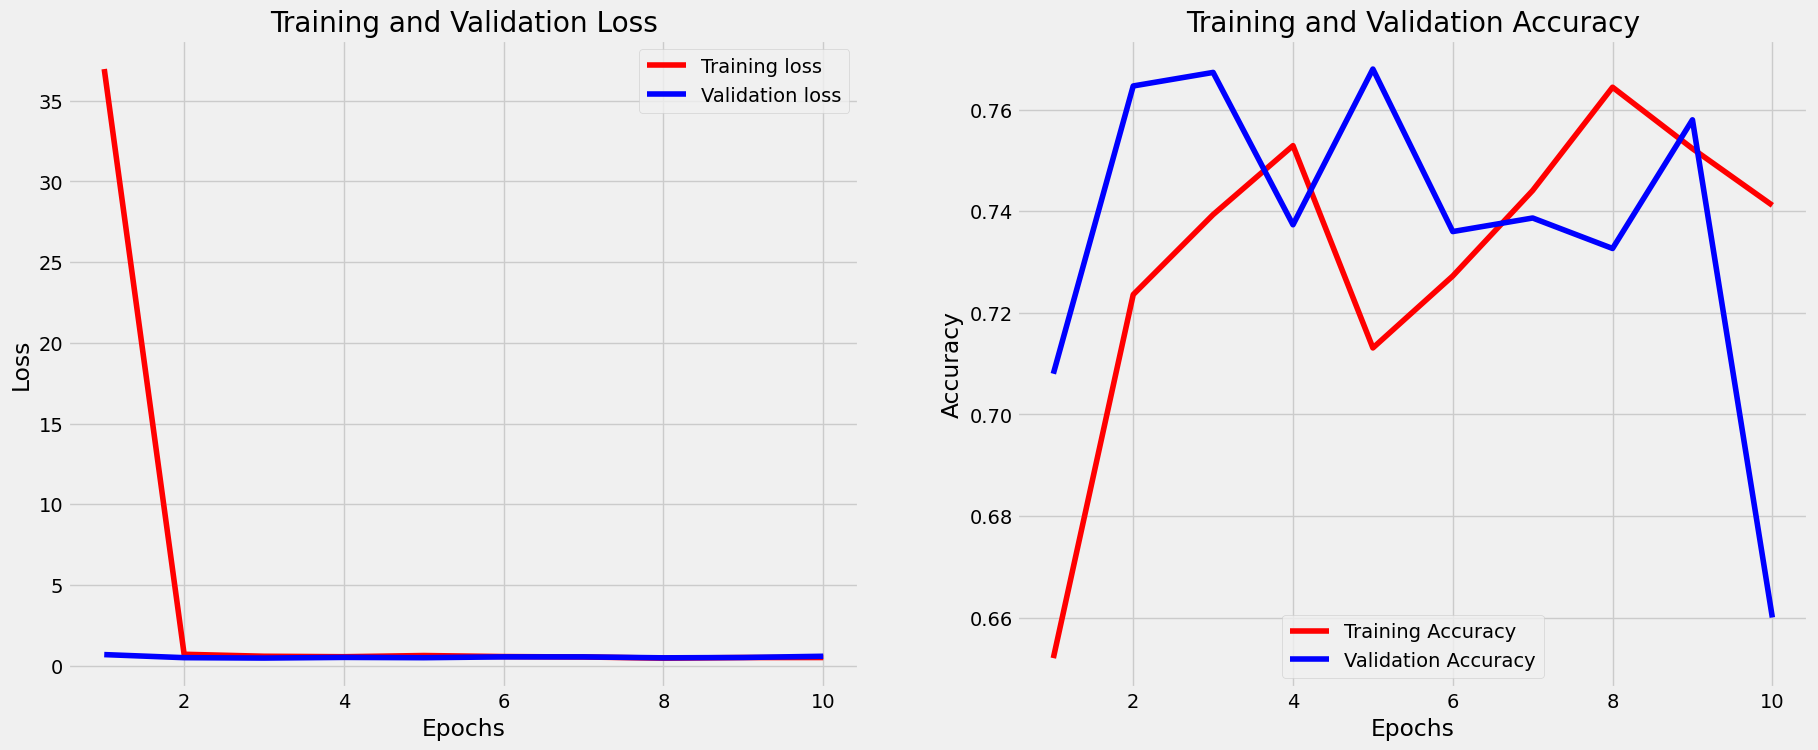

In [38]:
model_performance(history4, 10)

In [40]:
model5 = Sequential()
model5.add(Input(shape=img_shape))
model5.add(Flatten())
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(128, activation = 'relu'))
model5.add(Dense(64, activation = 'relu'))
model5.add(Dense(class_counts, activation = 'softmax'))

model5.compile(Adam(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history5=model5.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 175ms/step - accuracy: 0.5879 - loss: 11.2046 - val_accuracy: 0.7480 - val_loss: 0.9649
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - accuracy: 0.7556 - loss: 0.6971 - val_accuracy: 0.7273 - val_loss: 0.6381
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 151ms/step - accuracy: 0.7102 - loss: 0.7263 - val_accuracy: 0.6953 - val_loss: 0.5585
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - accuracy: 0.7472 - loss: 0.5140 - val_accuracy: 0.7613 - val_loss: 0.4982
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 165ms/step - accuracy: 0.7593 - loss: 0.4776 - val_accuracy: 0.7393 - val_loss: 0.5063
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - accuracy: 0.7510 - loss: 0.5155 - val_accuracy: 0.7240 - val_loss: 0.5509
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 159ms/step - accuracy: 0.7701 - loss: 0.4721 - val_accuracy: 0.7133 - val_loss: 0.5910
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - accuracy: 0.7808 - loss: 

In [41]:
loss, accuracy = model5.evaluate(valid_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 72%
Model Loss : 51%


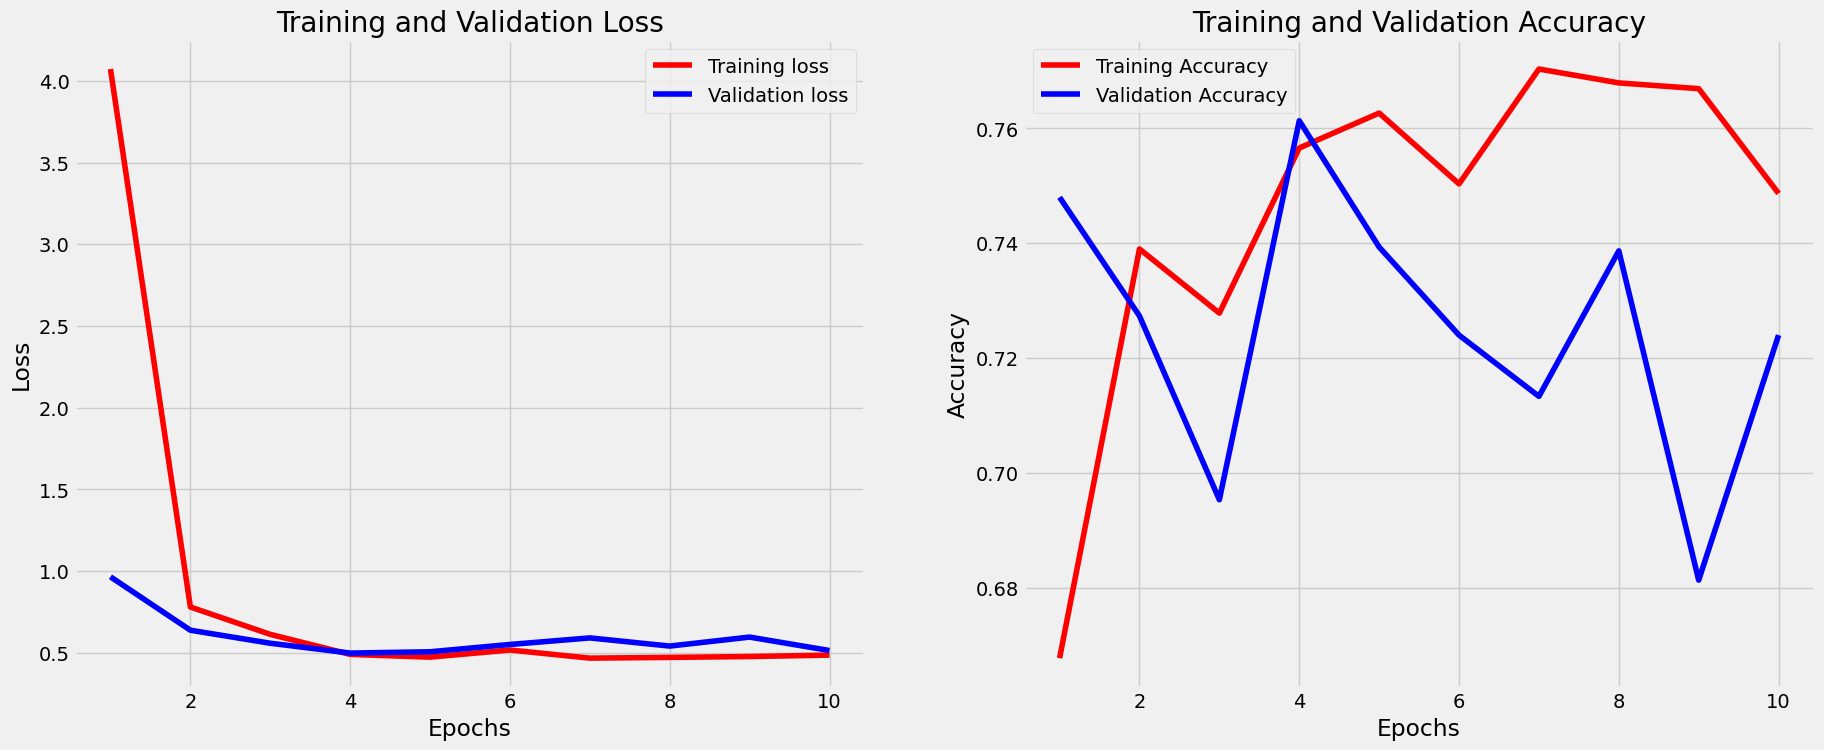

In [42]:
model_performance(history5, 10)

In [ ]:
model6 = Sequential()
model6.add(Input(shape=img_shape))
model6.add(Flatten())
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(64, activation = 'relu'))
model6.add(Dense(class_counts, activation = 'softmax'))

model6.compile(SGD(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history6=model6.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
308/375 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.5788 - loss: 0.8125 

In [ ]:
loss, accuracy = model6.evaluate(valid_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

In [ ]:
model_performance(history6, 10)

In [44]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.0 MB/s eta 0:00:00


In [48]:
# import keras_tuner as kt
# import matplotlib.pyplot as plt

# def model_builder(hp):
#   model = Sequential()
#   model.add(Input(shape=img_shape))
#   model.add(Flatten())

#   # ضبط عدد الوحدات في الطبقة الأولى
#   hp_units1 = hp.Int('units1', min_value=128, max_value=512, step=32)
#   model.add(Dense(units=hp_units1, activation='relu'))

#   # ضبط عدد الوحدات في الطبقة الثانية
#   hp_units2 = hp.Int('units2', min_value=64, max_value=128, step=32)
#   model.add(Dense(units=hp_units2, activation='relu'))

#   # ضبط عدد الوحدات في الطبقة الثالثة
#   hp_units3 = hp.Int('units3', min_value=32, max_value=64, step=32)
#   model.add(Dense(units=hp_units3, activation='relu'))

#   model.add(Dense(class_counts, activation='softmax'))

#   # ضبط معدل التعلم
#   hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#   model.compile(optimizer=Adamax(learning_rate=hp_learning_rate),
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])
#   return model

# # إنشاء Tuner
# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=3,
#                      directory='my_dir',
#                      project_name='intro_to_kt')

# # بدء البحث عن أفضل المعلمات
# tuner.search(train_gen,
#             epochs=10,
#             validation_data=valid_gen,
#             )

# # الحصول على أفضل نموذج وتدريبه
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(train_gen,
#                     epochs=10,
#                     verbose=1,
#                     validation_data=valid_gen,
#                     shuffle=False)



Trial 2 Complete [00h 02m 25s]
val_accuracy: 0.7473333477973938

Best val_accuracy So Far: 0.7699999809265137
Total elapsed time: 00h 05m 07s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
480               |512               |units1
96                |64                |units2
64                |32                |units3
0.01              |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
142/375 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - accuracy: 0.3539 - loss: 258.0014

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(class_counts, activation='softmax'))

# ... (باقي كود النموذج)

In [ ]:
# x_train, y_train = next(train_gen)
# x_val, y_val = next(valid_gen)

#BINARY CLASSIFICATION

In [ ]:
!kaggle datasets download mysarahmadbhat/lung-cancer

Dataset URL: https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer
License(s): CC0-1.0
  0% 0.00/2.00k [00:00<?, ?B/s]
100% 2.00k/2.00k [00:00<00:00, 4.62MB/s]


In [ ]:
!unzip lung-cancer.zip -d data

Archive:  lung-cancer.zip
  inflating: data/survey lung cancer.csv  


In [ ]:
df = pd.read_csv('data/survey lung cancer.csv')

In [ ]:
df.describe()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,62.673139,1.563107,1.569579,1.498382,1.501618,1.504854,1.673139,1.556634,1.556634,1.556634,1.579288,1.640777,1.469256,1.556634
std,8.210301,0.496806,0.495938,0.500808,0.500808,0.500787,0.469827,0.497588,0.497588,0.497588,0.494474,0.480551,0.499863,0.497588
min,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,62.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000
75%,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,87.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [ ]:
df.duplicated().sum()

33

In [ ]:
# remove duplicated
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
df.head(10)

# we need convert gender to number and scale age value

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
5,F,75,1,2,1,1,2,2,2,2,1,2,2,1,1,YES
6,M,52,2,1,1,1,1,2,1,2,2,2,2,1,2,YES
7,F,51,2,2,2,2,1,2,2,1,1,1,2,2,1,YES
8,F,68,2,1,2,1,1,2,1,1,1,1,1,1,1,NO
9,M,53,2,2,2,2,2,1,2,1,2,1,1,2,2,YES


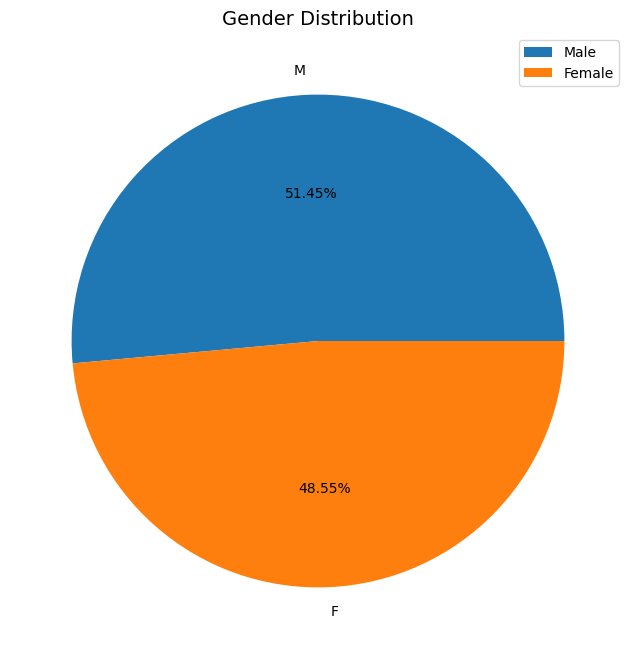

In [ ]:
gen_count=df["GENDER"].value_counts()
plt.figure(figsize=(10,8))
values=gen_count.values
labels=gen_count.index
plt.pie(values,labels=labels,autopct='%1.2f%%')
plt.title("Gender Distribution",fontsize='14')
plt.legend(["Male","Female"])
plt.show()

Text(0.5, 1.0, 'Gender Vs. Lung Cancer')

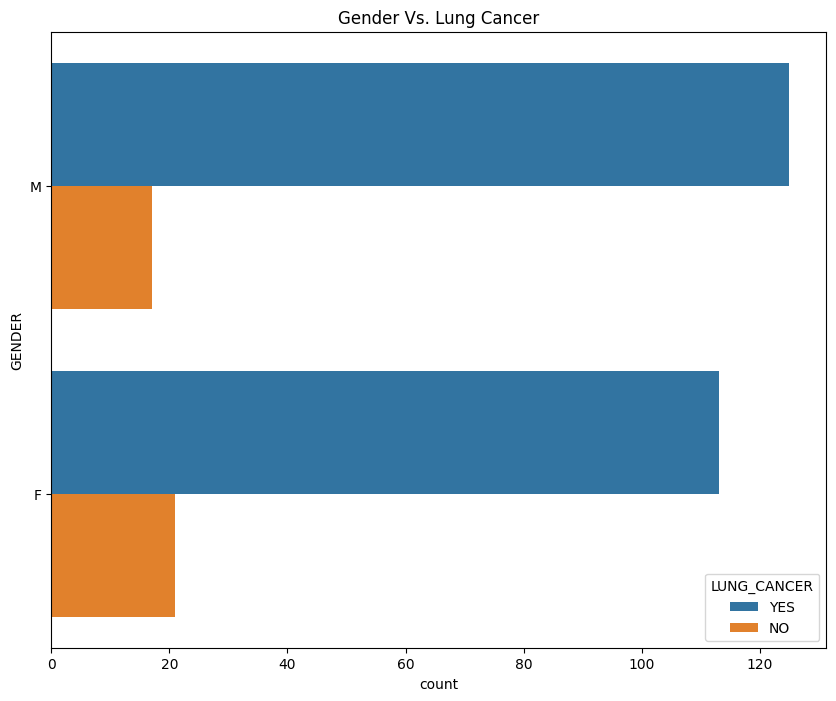

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(data=df,y="GENDER",hue="LUNG_CANCER")
plt.title("Gender Vs. Lung Cancer")

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})

# scaler = MinMaxScaler()
# df['AGE'] = scaler.fit_transform(df[['AGE']])

df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [ ]:
lung_key = {'YES' : 1, 'NO' : 0}

df['LUNG_CANCER'] = df['LUNG_CANCER'].map(lung_key)
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


<Axes: >

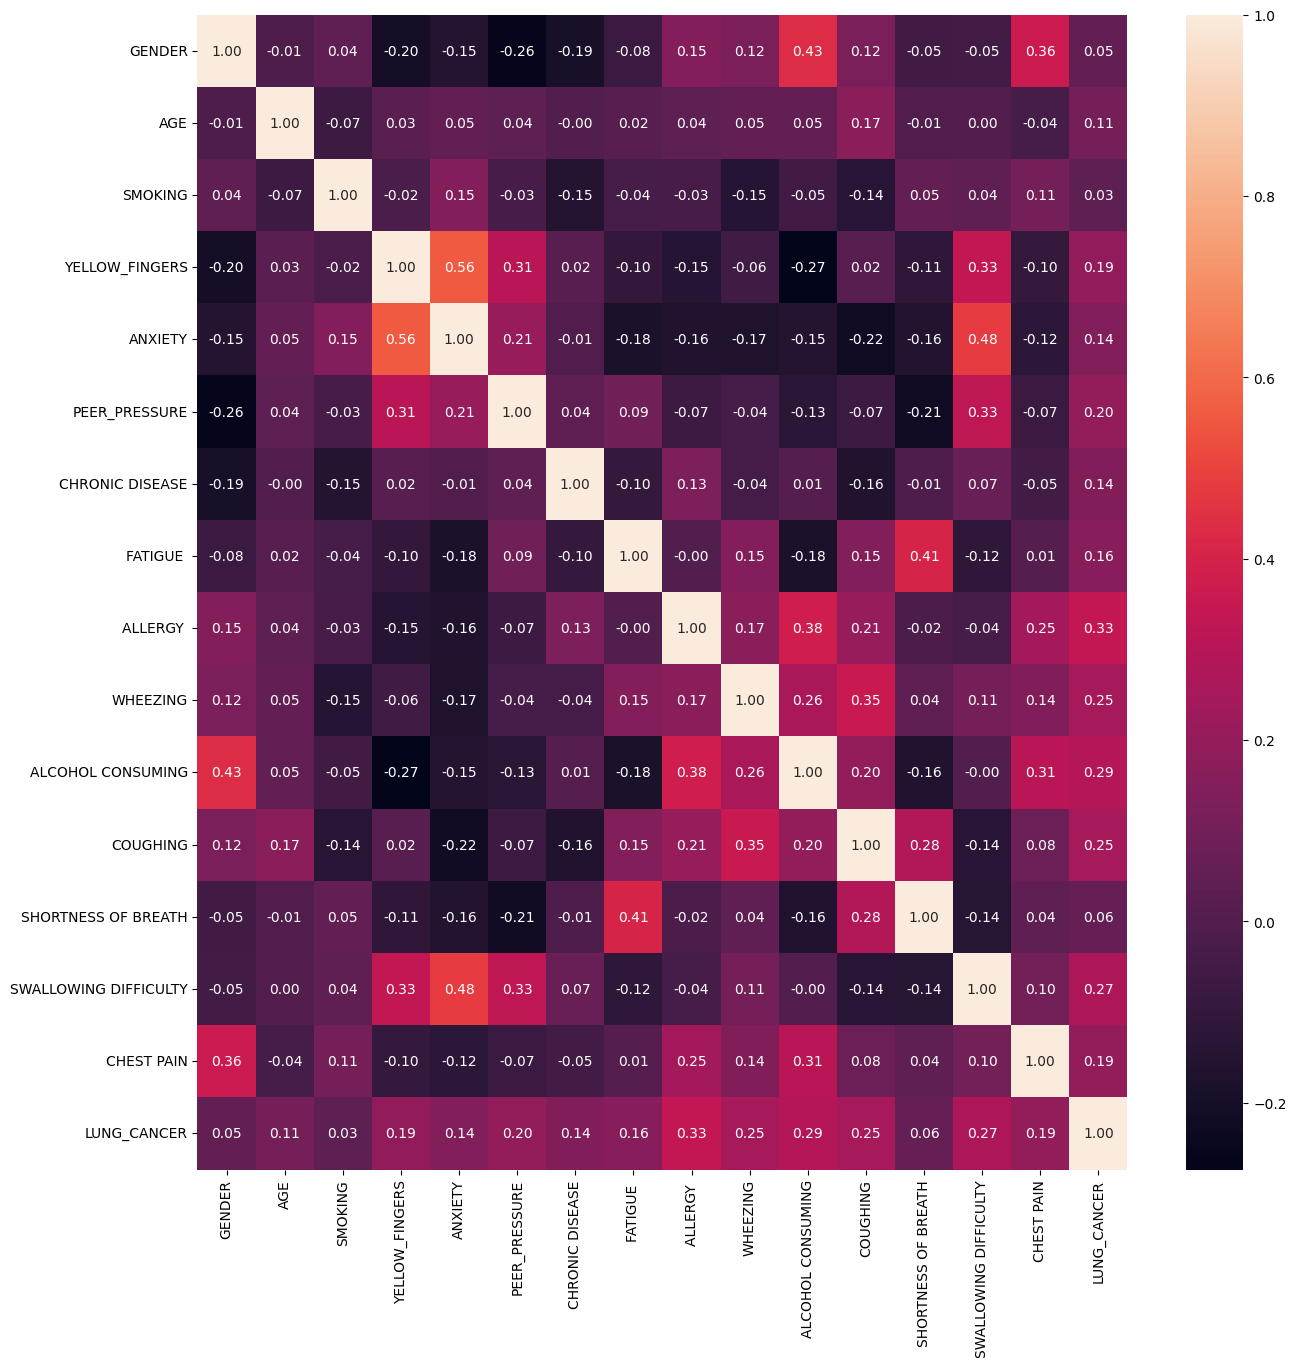

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,fmt='0.2f')

In [ ]:
# split data
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
y

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1])

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
age_index = 1

X_train_age = X_train[:, age_index].reshape(-1, 1)
X_test_age = X_test[:, age_index].reshape(-1, 1)


In [ ]:
X_train[:, age_index]

array([60, 38, 67, 55, 62, 59, 56, 65, 75, 77, 71, 66, 69, 62, 62, 73, 59,
       56, 68, 58, 71, 52, 62, 72, 52, 67, 74, 56, 55, 72, 73, 59, 47, 72,
       62, 55, 67, 64, 64, 77, 56, 55, 63, 57, 59, 78, 60, 59, 61, 76, 69,
       79, 55, 61, 54, 58, 71, 71, 61, 58, 55, 56, 65, 67, 62, 57, 75, 56,
       63, 72, 72, 67, 71, 67, 60, 74, 60, 59, 53, 64, 59, 63, 60, 70, 65,
       63, 64, 77, 63, 61, 87, 64, 44, 69, 64, 64, 56, 61, 64, 60, 60, 69,
       59, 54, 72, 59, 71, 69, 55, 63, 53, 56, 70, 63, 57, 56, 62, 70, 54,
       61, 59, 62, 68, 64, 74, 70, 64, 68, 68, 51, 47, 60, 78, 70, 54, 60,
       60, 67, 64, 48, 49, 68, 75, 52, 70, 64, 70, 63, 60, 49, 56, 74, 63,
       60, 60, 61, 58, 55, 59, 69, 51, 72, 74, 77, 68, 71, 81, 61, 54, 55,
       68, 58, 69, 67, 71, 57, 56, 67, 46, 67, 64, 77, 70, 68, 57, 53, 56,
       64, 64, 59, 51, 69, 77, 69, 59, 56, 47, 62, 70, 62, 59, 58, 64, 68,
       63, 70, 74, 76, 64, 81, 62, 70, 70, 60, 44, 55, 66, 49, 77, 72])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X_train_age_scaled = scaler.fit_transform(X_train_age)
X_test_age_scaled = scaler.transform(X_test_age)

X_train[:, age_index] = X_train_age_scaled.flatten()
X_test[:, age_index] = X_test_age_scaled.flatten()

In [ ]:
X_train.shape

(220, 15)

In [ ]:
def model_performance1(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(6, activation = 'relu'))
model.add(Dense(3, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'] )

history=model.fit(X_train,y_train, epochs= 10, batch_size = 4)

Epoch 1/10
55/55 [==============================] - 1s 2ms/step - loss: 0.4471 - accuracy: 0.8818
Epoch 2/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3483 - accuracy: 0.8818
Epoch 3/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3396 - accuracy: 0.8818
Epoch 4/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8818
Epoch 5/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3361 - accuracy: 0.8818
Epoch 6/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3353 - accuracy: 0.8818
Epoch 7/10
55/55 [==============================] - 0s 3ms/step - loss: 0.3350 - accuracy: 0.8818
Epoch 8/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3324 - accuracy: 0.8818
Epoch 9/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3315 - accuracy: 0.8818
Epoch 10/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3302 - accuracy: 0.8818


In [ ]:
loss, accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 79%
Model Loss : 50%


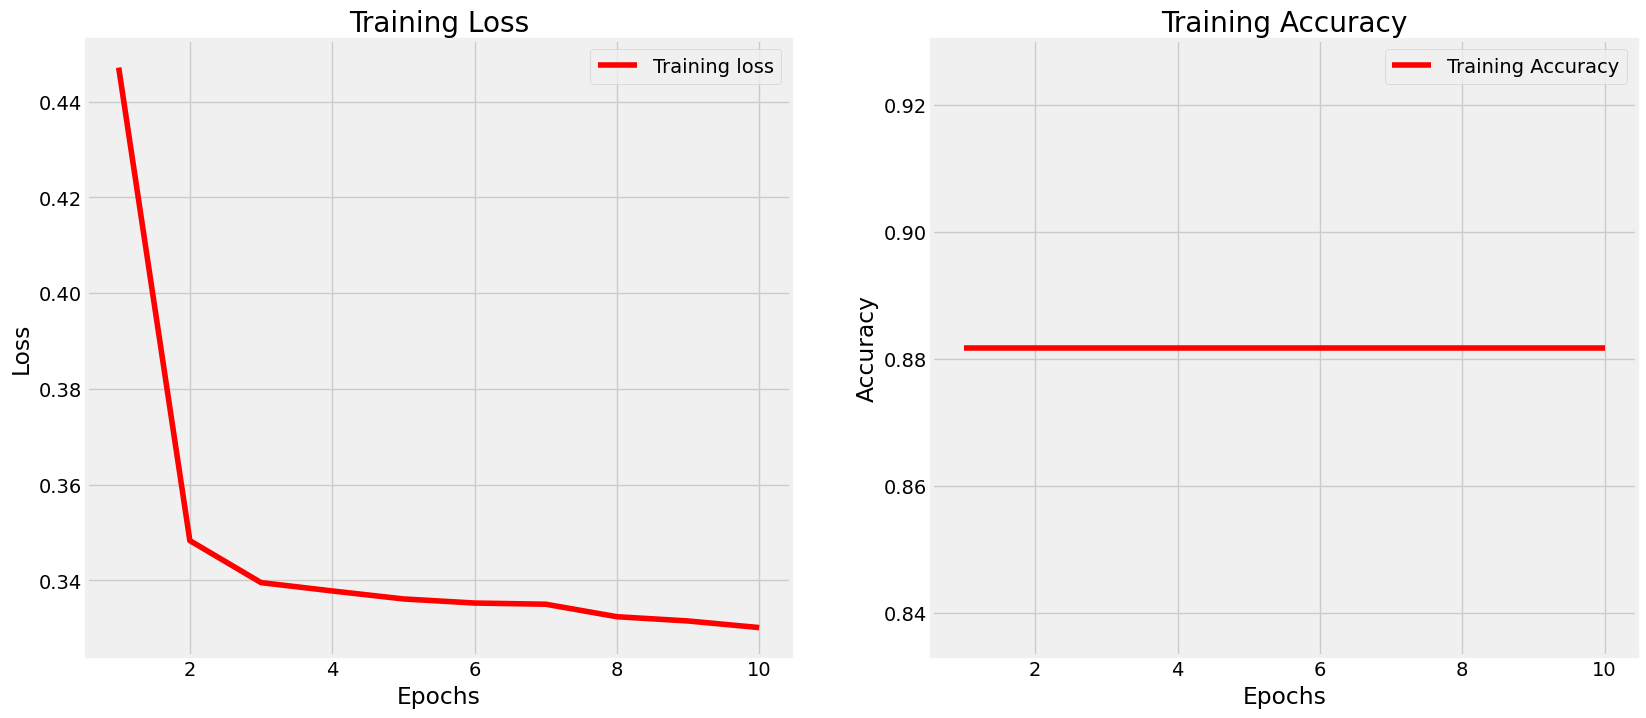

In [ ]:
model_performance1(history, 10)

In [ ]:
model1 = Sequential()
model1.add(Input(shape=(X_train.shape[1],)))
model1.add(Dense(10, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(5, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

model1.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'] )

history1=model1.fit(X_train,y_train, epochs= 10,batch_size = 4)

Epoch 1/10
55/55 [==============================] - 1s 2ms/step - loss: 0.5615 - accuracy: 0.6955
Epoch 2/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3786 - accuracy: 0.8636
Epoch 3/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.8818
Epoch 4/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8818
Epoch 5/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.8818
Epoch 6/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3655 - accuracy: 0.8818
Epoch 7/10
55/55 [==============================] - 0s 3ms/step - loss: 0.3609 - accuracy: 0.8818
Epoch 8/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3504 - accuracy: 0.8773
Epoch 9/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8773
Epoch 10/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3549 - accuracy: 0.8818


In [ ]:
loss, accuracy = model1.evaluate(X_test,y_test, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 79%
Model Loss : 49%


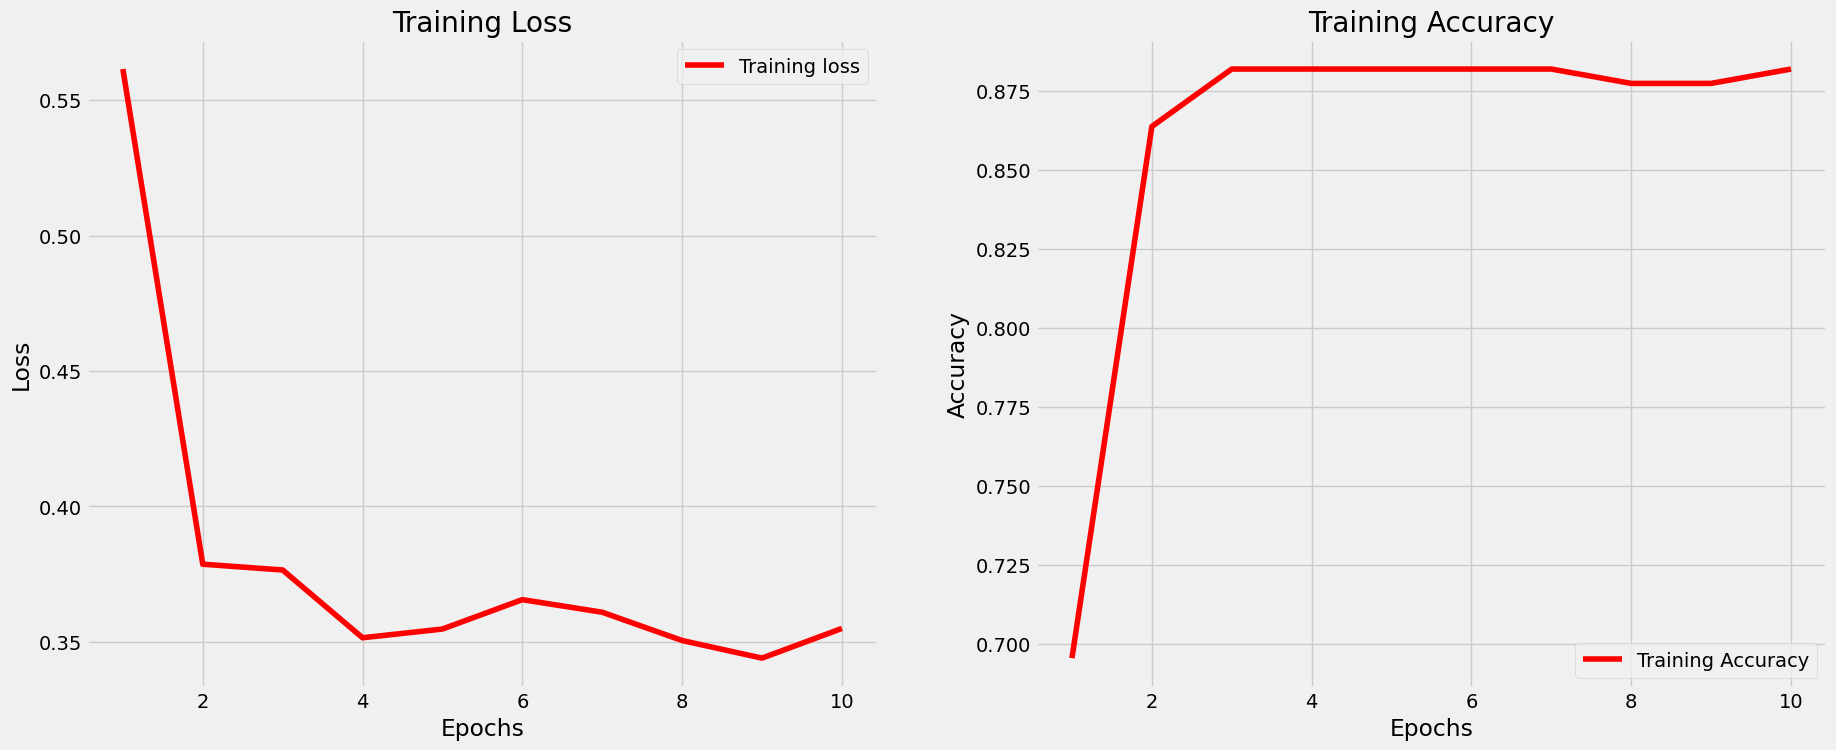

In [ ]:
model_performance1(history1, 10)